# REU Poster Figures

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

In [3]:
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

## Useful Functions

In [33]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

In [34]:
def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

In [35]:
def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [40]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
        
    temp_filt=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))
    for n in range(0,num):
        temp_filt[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')
    ds_filt=xr.DataArray(temp_filt,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})
    return ds_filt

In [41]:
def glider_var(ds_interp,ds_filt,variable='CT'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-ds_interp.CT).var()
    return var

## Housekeeping

In [56]:
np_param=[-155,-145,30,35,0,2000]
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
na_param=[-55,-45,40,45,0,2000]
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
io_param=[90,100,-15,-10,0,2000]
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")

In [57]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)
io_interp=get_ds_interp(io_ds,0,2000,3)

In [58]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
np_filt=get_ds_filt(np_interp,0.5,2.5,50)
na_filt=get_ds_filt(na_interp,0.5,2.5,50)
io_filt=get_ds_filt(io_interp,0.5,2.5,50)

In [59]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)
io_var=get_var(io_interp,io_filt)

## Data

#### Map of Boxes

In [60]:
np_lon,np_lat=np.average((np_param[0],np_param[1])),np.average((np_param[2],np_param[3]))
na_lon,na_lat=np.average((na_param[0],na_param[1])),np.average((na_param[2],na_param[3]))
so_lon,so_lat=np.average((so_param[0],so_param[1])),np.average((so_param[2],so_param[3]))
io_lon,io_lat=np.average((io_param[0],io_param[1])),np.average((io_param[2],io_param[3]))

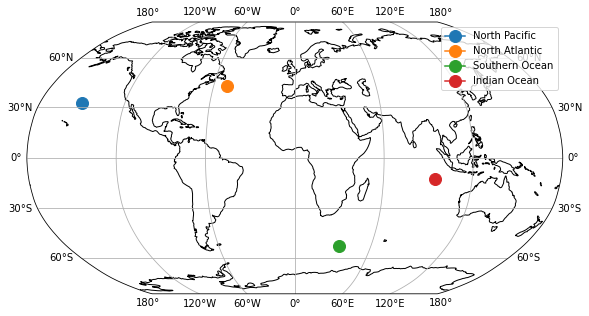

In [61]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np_lon,np_lat,transform=ccrs.PlateCarree(),label='North Pacific',marker='o',markersize=12)
plt.plot(na_lon,na_lat,transform=ccrs.PlateCarree(),label='North Atlantic',marker='o',markersize=12)
plt.plot(so_lon,so_lat,transform=ccrs.PlateCarree(),label='Southern Ocean',marker='o',markersize=12)
plt.plot(io_lon,io_lat,transform=ccrs.PlateCarree(),label='Indian Ocean',marker='o',markersize=12)
plt.legend()

#### All Boxes Results

In [62]:
for interp in (np_interp,na_interp,so_interp,io_interp):
    interp.N_PROF_NEW.attrs.update({'long_name':'Relative Profile Number'})
    interp.TEMP.attrs.update({'long_name':'Temperature','units':'°C'})
    interp.PRES_INTERPOLATED.attrs.update({'long_name':'Interpolated Pressure','units':'db'})

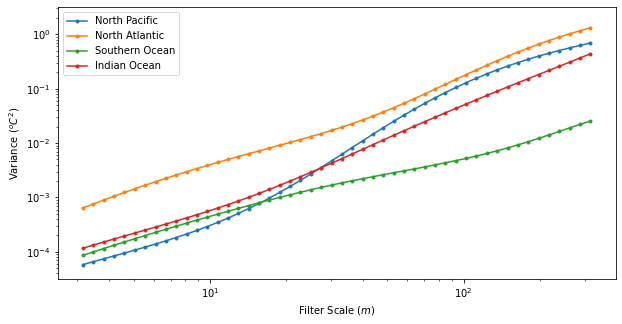

In [63]:
plt.figure(figsize=(10,5))
xs=[np_nmf.FILT_SCALE,na_nmf.FILT_SCALE,so_nmf.FILT_SCALE,io_nmf.FILT_SCALE]
ys=[np_nmv,na_nmv,so_nmv,io_nmv]
titles=['North Pacific','North Atlantic','Southern Ocean','Indian Ocean']

for n in range(0,4):
    plt.plot(xs[n],ys[n],'.-',label=titles[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Filter Scale ($m$)")
    plt.ylabel("Variance ($^oC^2$)")
    plt.ylim(10**-4.5,10**0.5)
    #plt.xticks([])
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()

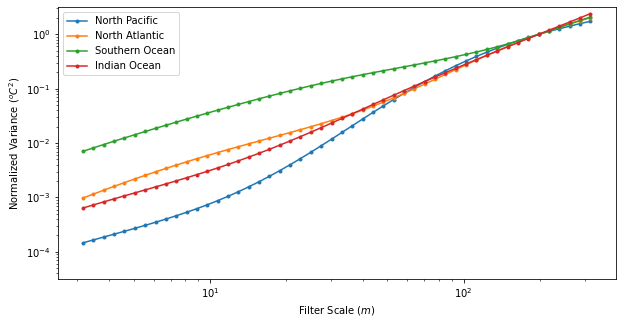

In [64]:
plt.figure(figsize=(10,5))

yis=[np_nmv/np_nmv[-6],na_nmv/na_nmv[-6],so_nmv/so_nmv[-6],io_nmv/io_nmv[-6]]
for n in range(0,4):
    plt.plot(xs[n],yis[n],'.-',label=titles[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Filter Scale ($m$)")
    plt.ylabel("Normalized Variance ($^oC^2$)")
    plt.ylim(10**-4.5,10**0.5)
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()

In [65]:
np_spec=xrft.power_spectrum(np_interp.TEMP - np_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)
na_spec=xrft.power_spectrum(na_interp.TEMP - na_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)
so_spec=xrft.power_spectrum(so_interp.TEMP - so_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)
io_spec=xrft.power_spectrum(io_interp.TEMP - io_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


#### Methods Flowchart

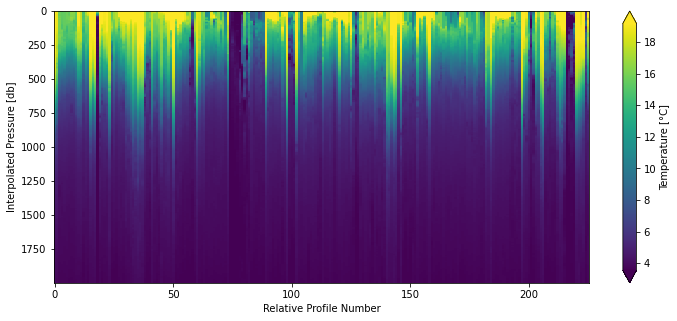

In [66]:
plt.figure(figsize=(12,5))
na_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

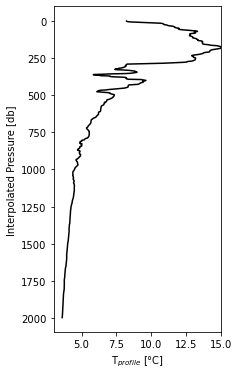

In [67]:
plt.figure(figsize=(3,6))
profile=na_interp.TEMP.isel(N_PROF=200)
profile.plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{profile}$ [°C]')
plt.xlim(3,15)
plt.title('');

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


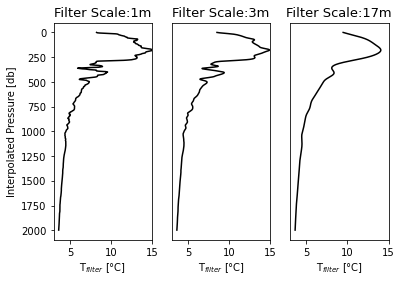

In [68]:
filt1,filt2,filt3=12,29,-4
filts=[na_filt.isel(N_PROF=200,FILT_SCALE=filt1),na_filt.isel(N_PROF=200,FILT_SCALE=filt2),na_filt.isel(N_PROF=200,FILT_SCALE=filt3)]
labels=[int(round(float(na_filt.FILT_SCALE[filt1]))),int(round(float(na_filt.FILT_SCALE[filt2]))),int(round(float(na_filt.FILT_SCALE[filt3])))]

plt.subplot(1,3,1)
filts[0].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{filter}$ [°C]')
plt.ylabel('Interpolated Pressure [db]')
plt.xlim(3,15)
plt.title('Filter Scale:{}m'.format(labels[0]),fontsize=13)

plt.subplot(1,3,2)
filts[1].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{filter}$ [°C]')
plt.xlim(3,15)
plt.title('Filter Scale:{}m'.format(labels[1]),fontsize=13)

plt.subplot(1,3,3)
filts[2].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{filter}$ [°C]')
plt.xlim(3,15)
plt.title('Filter Scale:{}m'.format(labels[2]),fontsize=13);

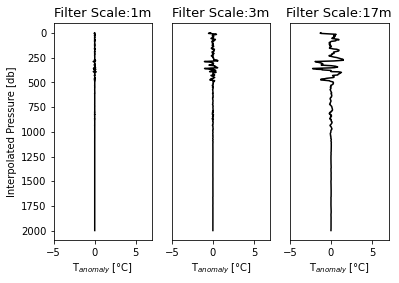

In [69]:
anoms=[profile-filts[0],profile-filts[1],profile-filts[2]]

plt.subplot(1,3,1)
anoms[0].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.xlabel('T$_{anomaly}$ [°C]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}m'.format(labels[0]),fontsize=13)

plt.subplot(1,3,2)
anoms[1].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{anomaly}$ [°C]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}m'.format(labels[1]),fontsize=13)

plt.subplot(1,3,3)
anoms[2].plot(y='PRES_INTERPOLATED',color='black')
plt.gca().invert_yaxis()
plt.yticks([])
plt.ylabel('')
plt.xlabel('T$_{anomaly}$ [°C]')
plt.xlim(-5,7)
plt.title('Filter Scale:{}m'.format(labels[2]),fontsize=13);

Text(0, 0.5, 'Variance ($^oC^2$)')

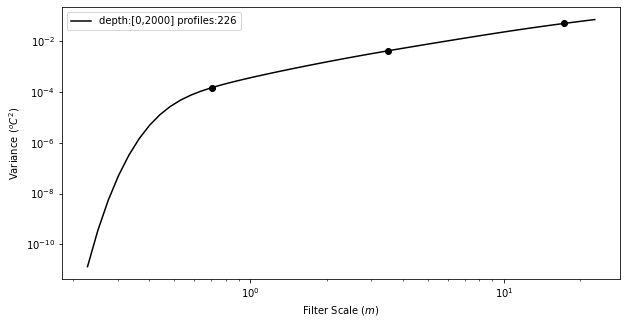

In [71]:
plt.figure(figsize=(10,5))

plt.plot(na_filt.FILT_SCALE[filt1],na_var[filt1],'o',color='black')
plt.plot(na_filt.FILT_SCALE[filt2],na_var[filt2],'o',color='black')
plt.plot(na_filt.FILT_SCALE[filt3],na_var[filt3],'o',color='black')
plt.plot(na_filt.FILT_SCALE,na_var,'-',color='black',label='depth:[0,2000] profiles:{}'.format(na_filt.N_PROF.shape[0]))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
#plt.ylim(10**-5.5,10**2);

#### Profile Plots

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


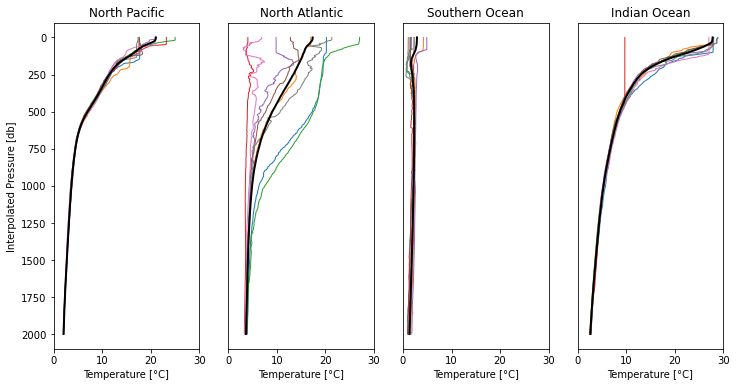

In [72]:
plt.figure(figsize=(12,6))

profiles=[0,25,50,75,-75,-50,-25,-1]

na_imean=na_interp.TEMP.mean('N_PROF')
np_imean=np_interp.TEMP.mean('N_PROF')
so_imean=so_interp.TEMP.mean('N_PROF')
io_imean=io_interp.TEMP.mean('N_PROF')

for n in range(0,len(profiles)):
    plt.subplot(1,4,2)
    prof=na_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.yticks([])
    plt.ylabel('')
    plt.xlabel('Temperature [°C]')
    plt.title("North Atlantic")
    plt.xlim(0,30)
    
    plt.subplot(1,4,1)
    prof=np_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.xlim(0,30)
    plt.ylabel("Interpolated Pressure [db]")
    plt.xlabel('Temperature [°C]')
    plt.title("North Pacific")
    
    plt.subplot(1,4,3)
    prof=so_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel('')
    plt.yticks([])
    plt.xlim(0,30)
    plt.xlabel('Temperature [°C]')
    plt.title('Southern Ocean')
    
    plt.subplot(1,4,4)
    prof=io_interp.isel(N_PROF=profiles[n])
    plt.plot(prof.TEMP,prof.PRES_INTERPOLATED,lw=1)
    plt.ylabel('')
    plt.yticks([])
    plt.xlim(0,30)
    plt.xlabel('Temperature [°C]')
    plt.title('Indian Ocean')

plt.subplot(1,4,2)
plt.plot(na_imean.data,na_imean.PRES_INTERPOLATED,color='black',lw=2)
plt.gca().invert_yaxis()

plt.subplot(1,4,1)
plt.plot(np_imean.data,np_imean.PRES_INTERPOLATED,color='black',lw=2)
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
plt.plot(so_imean.data,so_imean.PRES_INTERPOLATED,color='black',lw=2)
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.plot(io_imean.data,io_imean.PRES_INTERPOLATED,color='black',lw=2)
plt.gca().invert_yaxis()

## Glider vs Argo

#### Spatial Extent

In [88]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
gselect_filt=glider_ds_filt(select,1,3,50)
gselect_var=glider_var(select,select_filt)

#argo box
box=xr.open_dataset('202206_lon:(30,39)_lat:(-54,-50).nc')
aselect=get_ds_interp(box,200,900,4)
aselect_filt=get_ds_filt(box_interp,1,3,50)
aselect_var=get_var(box_interp,box_filt)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


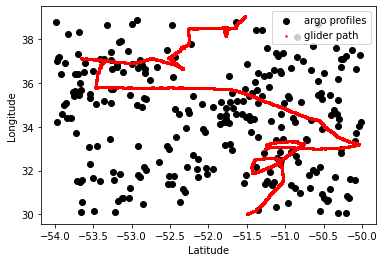

In [89]:
plt.scatter(box_interp.LATITUDE,box_interp.LONGITUDE,color='black',label='argo profiles')
plt.scatter(ds_660_grid.latitude, ds_660_grid.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

#### Profiles

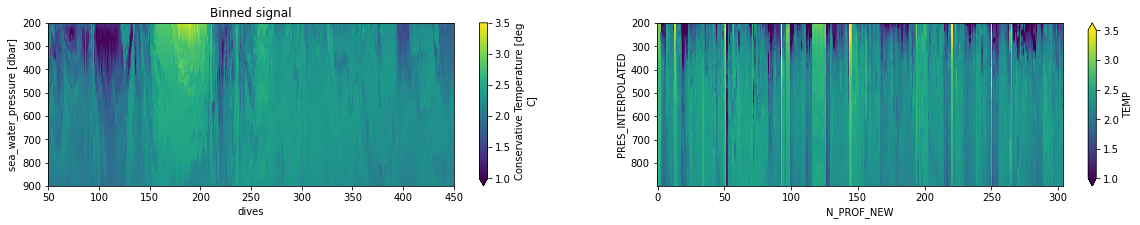

In [91]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(1,2,2)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()

#### Results Comparison

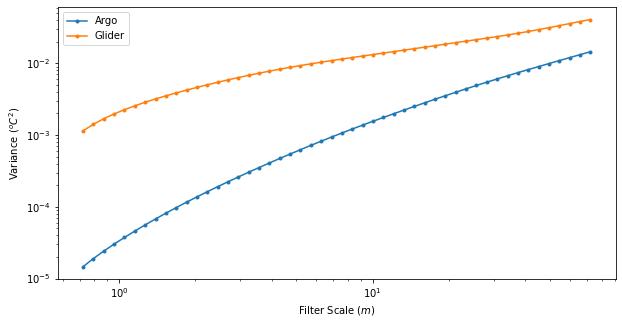

In [93]:
plt.figure(figsize=(10,5))
xs=[aselect_filt.FILT_SCALE,gselect_filt.filt_scale]
ys=[aselect_var,gselect_var]
titles=['Argo','Glider']

for n in range(0,2):
    plt.plot(xs[n],ys[n],'.-',label=titles[n])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Filter Scale ($m$)")
    plt.ylabel("Variance ($^oC^2$)")
    #plt.ylim(10**-4.5,10**0.5)
    #plt.xticks([])
    
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.legend()

In [111]:
test=np.array(aselect.TEMP)
test

array([[3.482    , 3.462    , 3.438    , ..., 2.612    , 2.611    ,
        2.612    ],
       [2.927    , 2.96     , 2.984    , ..., 2.561    , 2.561    ,
        2.561    ],
       [2.91     , 2.9      , 3.152    , ..., 2.459    , 2.459    ,
        2.459    ],
       ...,
       [1.506    , 1.544    , 1.575    , ..., 2.27     , 2.27     ,
        2.269    ],
       [1.279    , 1.284    , 1.2971905, ..., 2.259    , 2.254    ,
        2.252    ],
       [1.722    , 1.737    , 1.756    , ..., 2.271    , 2.269    ,
        2.268    ]], dtype=float32)

In [115]:
from scipy.fft import fft,ifft
N = len(test)
test_hat = fft(test)
test_hat_spec = np.abs(test_hat[1:int(N/2-1)]/(N))**2
np.sum(test_hat_spec)

1027.521

In [144]:
from scipy.ndimage import gaussian_filter1d

dx=float(aselect.PRES_INTERPOLATED[1]-aselect.PRES_INTERPOLATED[0])
l=dx*np.arange(1,N/4)

In [143]:
k_small=1/(2*L) #not sure what L is in this application
k_large=1/(2*dx)

NameError: name 'L' is not defined